In [ ]:
## Analysis of the output of the simulation

The notebook should be run with the simulation_metacom_class in the same folder

In [43]:
import os
import pandas as pd
import scipy as sc
import pickle
from __future__ import division

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from simulation_metacom_class import *

Function to calculate the octaves

In [44]:
def oct_calc(abundance_vect):
    """Calculates the octaves of an abundance array.
    abundance_vect: pandas.series of abundances
    """    
    #converts abundances into which bin they belong to. vector operation
    octaves_sps_belong = sc.floor(sc.log2(abundance_vect)).astype(int)
    #how many octaves for this community? how long the octaves vect needs to be add
    #for the 0. the max + 1 to count the 0 as well
    nbins = sc.amax(octaves_sps_belong) + 1
    oct_vect = [0] * nbins
    for i in octaves_sps_belong:
        oct_vect[i] = oct_vect[i] + 1
    
    return oct_vect


Function to calculate the octaves of an array

In [45]:
def samples_oct_list(abund_data):
    """Calculates the octaves of a set of communities in a pandas dataframe
    abund_data: Pandas dataframe where the communies are in columns and the species
    in rows
    """    
    oct_list = []
    for i in abund_data.columns:
        abundance_vect_nozeros = abund_data[abund_data.loc[:,i] != 0].loc[:,i]        
        oct_list.append(oct_calc(abundance_vect_nozeros))
    
    return oct_list

Function to calculate the indices that measure the difference between the octaves of the real data and the simulated data

In [46]:
def diff_index_calc(oct_abund_list1, oct_abund_list2):
    """Calculates and index of disimilarity between two lists of octaves vectors.
    Oct_abund_list: List of list of octaves, one list of octaves for each tree hole
    It's meant to compare the octaves of real data and simulated data.
    The global difference between the octaves of all tree holes is summarize summing
    the difference for each tree hole.
    Output: tuple(relative index / abusolute index) 
    relative index: is how big is the difference between each of the bins relative 
    to the mean between the two     
    absolute index: total number of individulas that are in different bins    
    """
    rel_index_list = []
    abs_index_list = []
    smty_index_list = []
    for i in range(10):
        abund_data_array = sc.asarray(oct_abund_list1[i], dtype='double')
        abund_sim_array = sc.asarray(oct_abund_list2[i], dtype = 'double')
        
        # make the length of the arrays similar to each other
        if len(abund_data_array) < len(abund_sim_array):
            small_len = abund_data_array
            long_len = abund_sim_array
        else:
            small_len = abund_sim_array
            long_len = abund_data_array
        diff = len(long_len) - len(small_len)        
        small_len = sc.append(small_len, [0]*diff)
           
        relative_index_vect = abs(long_len - small_len)/long_len   
        rel_index_list.append(sum(relative_index_vect)/len(relative_index_vect))
        
        absolute_index_vect = abs(long_len - small_len)
        abs_index_list.append(sum(absolute_index_vect)/len(absolute_index_vect))
        
        similarity_index_vect = []
        for i in range(len(long_len)):
            similarity_index_vect.append(sc.minimum(long_len[i], small_len[i])/sc.amax([long_len[i], small_len[i]]))
            
        smty_index_list.append(sum(similarity_index_vect)/len(similarity_index_vect))         
        
    rel_index_final = sum(rel_index_list)/10
    abs_index_final = sum(abs_index_list)/10
    smty_index_final = sum(smty_index_list)/10
    
    return (rel_index_final, abs_index_final, smty_index_final)

Function to compare the octaves of the data and the octaves of the simulation. It requires that the real data to compare with has to have 10 samples/communities like the number of communities in the simulation, to be able to compare 1:1

In [47]:
def parms_comparator(path_to_simfiles, abund_data, n_sim):
    """Builds a dataframe with the parameters and the differece indices between the 
    octaves. It resamples the real data to make the community sizes of the simulated and the 
    real data equal and therefore comparable 
    path_to_simfiles: path to the folder where the files of the simulation are. The function
    looks for files called 'TH_metacom_sim%s.pkl where %s is the number of the simulation run.
    abund_data: dataframe with the abundance data of only one time point, and there 
    should be 10 samples/communities.
    n_sim: number of simulations
    """
    
    
    diff_df = pd.DataFrame(columns = ['m', 'cln', 'rel_diff_index', 'abs_diff_index', 'smty_index_final'])
    for i in range(1,n_sim):
        try:
            loaded_sim = pickle.load(open(os.path.join(path_to_simfiles,'TH_metacom_sim%s.pkl'%i), 'rb'))
        except:
            continue
            
        oct_sim_list = samples_oct_list(loaded_sim.sp_abund_df.iloc[:,1:11])    

        #I need the size of each tree hole to sample the same amount of ind from the data
        th_size = loaded_sim.sp_abund_df.sum(0)        
        # in order to sample abund_data I need to build like a metacommunity, each
        # sps has a weight
        abund_data_total_th = abund_data.sum(axis = 0)
        metacom = abund_data.div(abund_data_total_th, axis = 1)
        # sampling the each of the holes
        i = 0        
        sampled_data = pd.DataFrame()        
        for i in range(10):
            sampled_data = pd.concat([sampled_data, pd.Series(sc.random.choice(metacom.index, p = metacom.iloc[:,i], size = th_size[i+1])).value_counts()], axis = 1)
        sampled_data.columns = abund_data.columns    
        sampled_data.fillna(0, inplace = True)    
        oct_data_list = samples_oct_list(sampled_data)
        
        diff = diff_index_calc(oct_sim_list, oct_data_list)        
        #row = pd.DataFrame([loaded_sim.m, loaded_sim.cln, diff])    
        diff_df = diff_df.append({'m': loaded_sim.m, 'cln':loaded_sim.cln, 'rel_diff_index':diff[0], 'abs_diff_index':diff[1], 'smty_index_final':diff[2]},ignore_index = True)

    return diff_df


Let's run the functions. First we have to select samples from one time point of the real data.

## RESULTS

In [48]:
abund = pd.read_csv("../../Data/Processed_data/Samples1K_OTUs100/TH_abund.csv", header = 0, index_col = 0)
abiotic = pd.read_csv('../../Data/Processed_data/Samples1K_OTUs100/TreeHoles_Abiotic.csv', header = 0)
# I cant index the dates because the name of the column has a dot, and python
# recognizes as a method
#abund_data = abund[abiotic[abiotic.R\.date == '2015-09-29'].loc[:,'Location']]
# Change the name of the R.date column
name_list = abiotic.columns.tolist()
name_list[3] = "R_date"
abiotic.columns = name_list
# Select the samples from only one time point that has samples for the 10 tree holes
samples = abiotic[abiotic.R_date == '2015-09-29'].loc[:,['Samples_shortname', 'Location']]
samples.sort_values('Location', axis = 0, inplace = True)
samples = samples.loc[:,'Samples_shortname']
abund_data = abund[samples]
abund_data.columns

Index([u'RNA_ID29_09_15_THS_1', u'RNA_ID29_09_15_THS_2',
       u'RNA_ID29_09_15_THS_3', u'RNA_ID29_09_15_THS_4',
       u'RNA_ID29_09_15_THS_5', u'RNA_ID29_09_15_THS_6',
       u'RNA_ID29_09_15_THS_7', u'RNA_ID29_09_15_THS_8',
       u'RNA_ID29_09_15_THS_9', u'RNA_ID29_09_15_THS_10'],
      dtype='object')

In [49]:
loaded_sim = pickle.load(open('Third_sim/TH_metacom_sim2.pkl', 'rb'))
loaded_sim.sp_abund_df

,Tot_abund,TH0,TH1,TH2,TH3,TH4,TH5,TH6,TH7,TH8,TH9
ID,,,,,,,,,,,
3,2,1,0,0,0,0,0,0,0,1,0
4,2,0,1,0,0,0,0,0,0,1,0
6,70,4,4,5,9,12,7,8,6,7,8
7,4,1,0,1,0,0,1,0,0,0,1
9,3,0,0,0,1,0,0,1,0,1,0
11,5,0,1,0,1,1,1,0,0,0,1
12,3,1,1,0,0,1,0,0,0,0,0
13,3,0,0,1,1,0,0,0,1,0,0
16,1,1,0,0,0,0,0,0,0,0,0


Let's run it!

In [50]:
third_sim_comp = parms_comparator(path_to_simfiles="Third_sim",abund_data=abund_data, n_sim=25)
third_sim_comp.to_csv("Third_sim/Results/Goodnes_fit.csv", header=True)

No all the simulations are present. Let's order them according to the indices. Let's start with the relative index (third column) measures de difference but as a proportion of the mean of the two octaves.

In [51]:
third_sim_comp.sort_values('rel_diff_index', axis = 0)

,m,cln,rel_diff_index,abs_diff_index,smty_index_final
8,0.006314,905.883760,0.532541,70.607143,0.628483
21,0.094686,294.993174,0.535070,72.528571,0.621717
15,0.050615,570.614933,0.538551,72.045238,0.624893
3,0.091093,984.472289,0.550911,74.016667,0.618459
17,0.046467,943.904360,0.574502,70.950000,0.592138
4,0.096690,455.471611,0.597377,71.335714,0.608068
7,0.033286,204.951326,0.613244,71.690476,0.608762
9,0.023314,86.458218,0.617405,74.697619,0.596545
14,0.065292,129.876834,0.618093,70.842857,0.597873
18,0.061941,807.452916,0.623236,69.359524,0.606456


The simulation with the best parameters was one on row number 8 which is the simulation 11. Let's get the dataframe with the results and save it in csv so i can open it in R

In [58]:
best = pickle.load(open('Third_sim/TH_metacom_sim11.pkl', 'rb'))

In [59]:
(best.m, best.cln)

(0.0063138025810969842, 905.88375951689864)

In [60]:
best.sp_abund_df.to_csv('Third_sim/Results/abund_df_best.csv', header = True, index = True)

In [63]:
best.J_TH

RNA_ID01_09_15_THS_1     31353
RNA_ID01_09_15_THS_9     25752
RNA_ID01_09_15_THS_2     18436
RNA_ID01_09_15_THS_10    21122
RNA_ID01_09_15_THS_3     29768
RNA_ID01_09_15_THS_4     28403
RNA_ID01_09_15_THS_5     23222
RNA_ID01_09_15_THS_6     29360
RNA_ID01_09_15_THS_7     29761
RNA_ID01_09_15_THS_8     23374
dtype: int64

This simulation has less than 20 species over all the tree holes and with very low abundances, what about the others?


In [ ]:
#sp_rich = []
#for i in range(1,n_sim):
#    try:
#        loaded_sim = pickle.load(open(os.path.join(path_to_simfiles,'TH_metacom_sim%s.pkl'%i), 'rb'))
#    except:
#        continue
#    sp_rich.append()
        

In [42]:
#len(loaded_sim.sp_abund)

26054

According to this index, there is not much difference between most of the parameters. The best is the number 21, with m=  0.025329 and cln = 749.214602.
Let's do the same with the absoulute index, that measures the diference between octaves in number of individuals

In [9]:
third_sim_comp.sort_values('abs_diff_index', axis = 0)

,m,cln,rel_diff_index,abs_diff_index,smty_index
21,0.025329,749.214602,0.816623,135.648788,0.228619
13,0.055647,380.644887,0.821941,135.855960,0.227267
8,0.033286,204.951326,0.814380,135.896465,0.227302
9,0.006314,905.883760,0.813281,136.385657,0.226992
2,0.013485,344.455158,0.822375,136.571111,0.225913
16,0.050615,570.614933,0.827313,136.598081,0.225203
19,0.061941,807.452916,0.818320,136.631212,0.226834
12,0.059142,530.966337,0.841633,136.772626,0.225017
5,0.096690,455.471611,0.824027,137.033737,0.226661
15,0.065292,129.876834,0.819354,137.105051,0.226504


In [10]:
third_sim_comp.sort_values('smty_index', axis = 0, ascending = False)

,m,cln,rel_diff_index,abs_diff_index,smty_index
21,0.025329,749.214602,0.816623,135.648788,0.228619
8,0.033286,204.951326,0.814380,135.896465,0.227302
13,0.055647,380.644887,0.821941,135.855960,0.227267
9,0.006314,905.883760,0.813281,136.385657,0.226992
19,0.061941,807.452916,0.818320,136.631212,0.226834
5,0.096690,455.471611,0.824027,137.033737,0.226661
15,0.065292,129.876834,0.819354,137.105051,0.226504
10,0.023314,86.458218,0.822369,137.133131,0.226294
2,0.013485,344.455158,0.822375,136.571111,0.225913
18,0.046467,943.904360,0.821747,137.581818,0.225739


Both relative indices are very similar. The absolute error is different. But I think the other two are more accurateplot the winner simulation and the real data

## PLOTTING

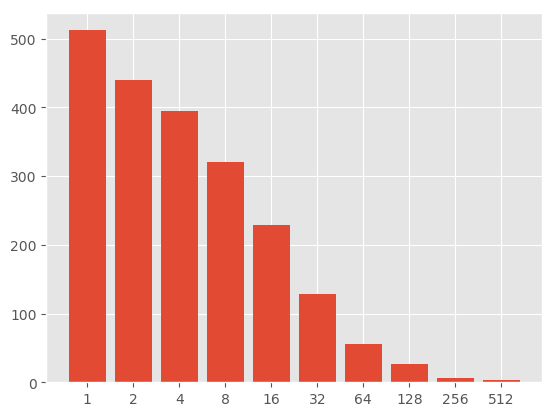

In [11]:
oct_data_list = samples_oct_list(abund_data)
oct_vect = oct_data_list[2]

upper = [1,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
plt.bar(sc.arange(len(oct_vect)), oct_vect)
plt.xticks(sc.arange(len(oct_vect)), upper[0:len(oct_vect)+1])
plt.show()

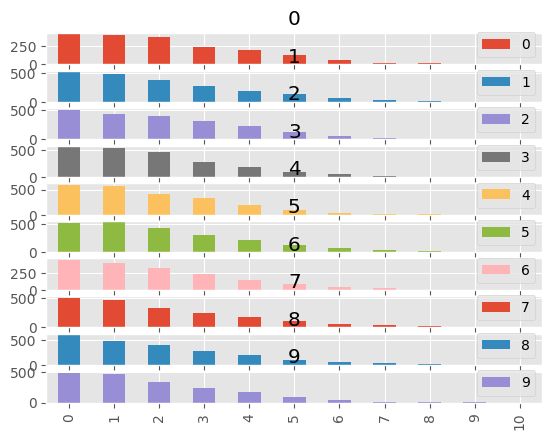

In [12]:
oct_data_df = pd.DataFrame(oct_data_list)
t_oct_data_df = oct_data_df.transpose()
t_oct_data_df.plot(kind='bar', subplots=True)
plt.show()

In an idea world I had all my simulations, and I could select the 21 by the number but it's not the case because there are few missing. I just have to look around the 21th file, which happens the number 23, there has been a bit a mix in the folder I think.

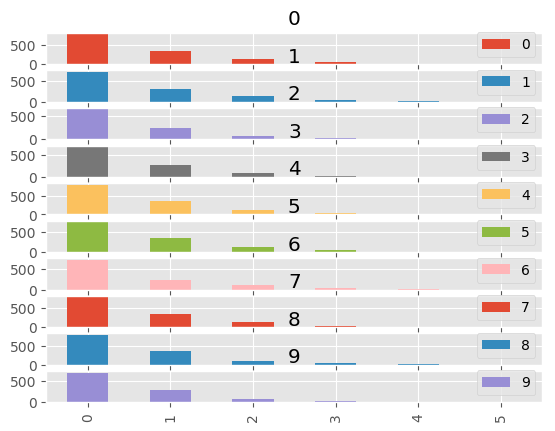

In [13]:
sim23 = pickle.load(open('Third_sim/TH_metacom_sim23.pkl', 'rb'))
oct_sim23_list = samples_oct_list(sim23.sp_abund_df.iloc[:,1:11])

oct_sim23_df = pd.DataFrame(oct_sim23_list)
t_oct_sim23_df = oct_sim23_df.transpose()
t_oct_sim23_df.plot(kind='bar', subplots=True)
plt.show()

Is this SAD more similar to the SAD of the data? well, being honest, to the naked eye it doesn't look very similar. For starters, the number of bins is very different, simulation between 3 and 5, real data between 7 and 9. The shape of the distribution is hard to see in this little graphs. Cand that be a problem of scale? What I mean is, does it not look similar because of the difference int he number of individuals?. Let's compare the number of individuals per sample in each dataset.

In [14]:
#Let's start with the real data
abund_data.sum(axis = 0)

RNA_ID29_09_15_THS_1     28900
RNA_ID29_09_15_THS_2     33254
RNA_ID29_09_15_THS_3     32987
RNA_ID29_09_15_THS_4     24320
RNA_ID29_09_15_THS_5     22837
RNA_ID29_09_15_THS_6     36490
RNA_ID29_09_15_THS_7     20486
RNA_ID29_09_15_THS_8     35661
RNA_ID29_09_15_THS_9     29444
RNA_ID29_09_15_THS_10    21392
dtype: int64

In [15]:
sum(abund_data.sum())

285771

In [17]:
# Now the simulate data
sim23.sp_abund_df.sum(axis = 0)

Tot_abund    26054
TH0           3135
TH1           2575
TH2           1844
TH3           2112
TH4           2977
TH5           2840
TH6           2322
TH7           2936
TH8           2976
TH9           2337
dtype: int64

In [18]:
# Let's calculate the ratio. By the way I add 'from __future__ import division'
# at the top so divisions return a double
n_ind_ratio = sim23.sp_abund_df.sum(axis = 0)[0]/sum(abund_data.sum())
n_ind_ratio

0.091170902575838694

## TRY TO SCALE THE SIMULATION ABUNDANCE (NO PROPER WAY OF DOING IT)

So the simulation is the 10 percent of the individuals present in the samples of the real data. What if get a ratio per tree hole and multiply the abundance of each simulated tree hole by it so the numbers are even and then perform the comparison? Let's make a new function then, actually two

In [19]:
def scl_parms_comparator(path_to_simfiles, abund_data, n_sim):
    """Builds a dataframe with the parameters and the differece indices between the 
    octaves.
    path_to_simfiles: path to the folder where the files of the simulation are
    abund_data: dataframe with the abundance data of only one time point, and there 
    should be 10 samples/communities.
    n_sim: number of simulations
    """
    oct_data_list = samples_oct_list(abund_data)
    
    diff_df = pd.DataFrame(columns = ['m', 'cln', 'rel_diff_index', 'abs_diff_index'])
    for i in range(1,26):
        try:
            loaded_sim = pickle.load(open(os.path.join(path_to_simfiles,'TH_metacom_sim%s.pkl'%i), 'rb'))
        except:
            continue
        scl_sim = scale_sim_data(abund_data, loaded_sim.sp_abund_df.iloc[:,1:11])            
        oct_sim_list = samples_oct_list(scl_sim)    
        
        
        diff = diff_index_calc(oct_sim_list, oct_data_list)        
        #row = pd.DataFrame([loaded_sim.m, loaded_sim.cln, diff])    
        diff_df = diff_df.append({'m': loaded_sim.m, 'cln':loaded_sim.cln, 'rel_diff_index':diff[0], 'abs_diff_index':diff[1]},ignore_index = True)

    return diff_df

In [20]:
# change the simulated abundance data so the total number of individuals per sample
# is equal to the real data
def scale_sim_data(abund_data, sim_data):
    """ Scales the abundances of the simulated data so the total number of individuals
    in each samples is the same in the simulated data and in the real data. 
    sim_data: pandas df with 10 columns with abundance data
    """
    for i in range(10):
        scaling_factor = abund_data.sum(axis = 0)[i-1]/sim_data.sum(axis = 0)[i]
        sim_scl = sim_data * scaling_factor 
    
    return sim_scl    


Let's run the new functions!

In [21]:
third_sim_comp_scl = scl_parms_comparator(path_to_simfiles="Third_sim",abund_data=abund_data, n_sim=25)

Let's order it again

In [22]:
third_sim_comp_scl.sort_values('rel_diff_index', axis = 0)

,m,cln,rel_diff_index,abs_diff_index
1,0.080522,429.543044,inf,202.650202
20,0.017950,52.583082,inf,201.617475
19,0.061941,807.452916,inf,198.953030
18,0.046467,943.904360,inf,197.016566
17,0.075553,848.082843,inf,199.352727
16,0.050615,570.614933,inf,197.201212
15,0.065292,129.876834,inf,200.799899
14,0.071983,674.059424,inf,201.425253
13,0.055647,380.644887,inf,198.845556
12,0.059142,530.966337,inf,201.470909


In [23]:
third_sim_comp.sort_values('abs_diff_index', axis = 0)

,m,cln,rel_diff_index,abs_diff_index,smty_index
21,0.025329,749.214602,0.816623,135.648788,0.228619
13,0.055647,380.644887,0.821941,135.855960,0.227267
8,0.033286,204.951326,0.814380,135.896465,0.227302
9,0.006314,905.883760,0.813281,136.385657,0.226992
2,0.013485,344.455158,0.822375,136.571111,0.225913
16,0.050615,570.614933,0.827313,136.598081,0.225203
19,0.061941,807.452916,0.818320,136.631212,0.226834
12,0.059142,530.966337,0.841633,136.772626,0.225017
5,0.096690,455.471611,0.824027,137.033737,0.226661
15,0.065292,129.876834,0.819354,137.105051,0.226504


It gives quite similar results than previously. It would be nice to plot the scaled octaves

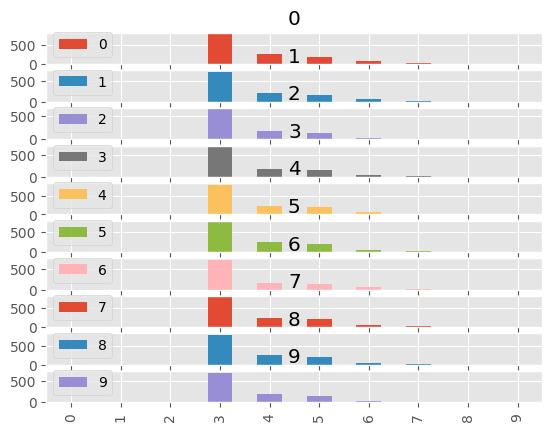

In [24]:
sim23 = pickle.load(open('Third_sim/TH_metacom_sim23.pkl', 'rb'))
scl_sim23 = scale_sim_data(abund_data, sim23.sp_abund_df.iloc[:,1:11])
scl_oct_sim23_list = samples_oct_list(scl_sim23)

scl_oct_sim23_df = pd.DataFrame(scl_oct_sim23_list)
t_scl_oct_sim23_df = scl_oct_sim23_df.transpose()
t_scl_oct_sim23_df.plot(kind='bar', subplots=True)
plt.show()

It didn't work that nicely because the scaling function only multiplies. It does not create new rare individuals, basicaly is not a simulation!. So the small abundances get multiplied and therefore the small octaves get emtpy because there's not small abundance any more. Let's compare the scaled and the non scaled abund df's

In [25]:
# First the scaled one
scl_sim23

,TH0,TH1,TH2,TH3,TH4,TH5,TH6,TH7,TH8,TH9
ID,,,,,,,,,,
3,12.599059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.599059,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.599059,0.000000
6,100.792469,113.391528,50.396234,75.594352,125.990586,50.396234,88.193410,100.792469,100.792469,88.193410
7,25.198117,0.000000,0.000000,0.000000,12.599059,25.198117,0.000000,0.000000,0.000000,0.000000
9,12.599059,0.000000,12.599059,0.000000,0.000000,0.000000,0.000000,0.000000,12.599059,25.198117
10,12.599059,0.000000,0.000000,12.599059,12.599059,12.599059,0.000000,0.000000,0.000000,0.000000
11,0.000000,12.599059,0.000000,0.000000,12.599059,12.599059,0.000000,0.000000,12.599059,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,12.599059,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,12.599059,0.000000,12.599059,0.000000,0.000000,12.599059,0.000000


In [26]:
# The non scaled one
sim23.sp_abund_df

,Tot_abund,TH0,TH1,TH2,TH3,TH4,TH5,TH6,TH7,TH8,TH9
ID,,,,,,,,,,,
3,2,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,1,0
6,71,8,9,4,6,10,4,7,8,8,7
7,5,2,0,0,0,1,2,0,0,0,0
9,5,1,0,1,0,0,0,0,0,1,2
10,4,1,0,0,1,1,1,0,0,0,0
11,4,0,1,0,0,1,1,0,0,1,0
12,1,0,0,0,0,0,1,0,0,0,0
13,3,0,0,0,1,0,1,0,0,1,0


In [27]:
# Let's compare the maximum abundance value, that gives the maximum number of bins/octaves
[sc.amax(scl_sim23), sc.amax(sim23.sp_abund_df)]

[TH0    491.363286
 TH1    377.971759
 TH2    302.377407
 TH3    403.169876
 TH4    453.566110
 TH5    478.764228
 TH6    327.575524
 TH7    516.561404
 TH8    428.367993
 TH9    440.967052
 dtype: float64, Tot_abund    329
 TH0           39
 TH1           30
 TH2           24
 TH3           32
 TH4           36
 TH5           38
 TH6           26
 TH7           41
 TH8           34
 TH9           35
 dtype: int64]

So everything get's multiplied by 12 basically, which is a lot. I think the best way to do this would be to take in account the scaling difference in the difference index, without multiplying the abundances